# Iterative Solvers 4 - Preconditioning

## The basic idea

For both the GMRES method and CG we have seen that the eigenvalue distribution is crucial for fast convergence. In both cases we would like the eigenvalues of the matrix be clustered close together and be well separated from zero. Unfortunately, in many applications the matrices that arise naturally are badly behaved in this respect. Preconditioning is a strategy to try to modify a linear system so that it becomes more ameniable to iterative solvers. Preconditioning is one of the most active research areas and crucial for the solution of linear systems of equations with millions or even billions of unknowns.

Consider the linear system of equations

$$
Ax = b
$$

In its basic form the idea of preconditioning is to multiply the system with a matrix $P^{-1}$ that is some kind of approximation to $A^{-1}$, that is $P^{-1}\approx A^{-1}$ in some sense (making this precise is the difficult bit).

We obtain either the left-preconditioned system

$$
P^{-1}Ax = P^{-1}b
$$

or the right-preconditioned system

$$
AP^{-1}y = b,
$$

where in the latter case we then additionally need to solve $Px=y$.

Classes of preconditioners include

* SPAI (Sparse Approximate Inverses)
* Incomplete LU Decomposition
* Incomplete Cholesky Decomposition
* Splitting Preconditioners
* Algebraic Multigrid Methods

These are also known as **algebraic preconditioners**. They consider the matrix $A$ and try to find an approximation to $A$ that is easily invertible.

A different class of preconditioners are **analytic preconditioners**. These are preconditioners that are often constructed as problems to PDEs that are easier to solve than the original PDE but still approximate to some sense the underlying physics of the problem.

## Sparse Approximate Inverse

As example of the class of algebraic preconditioners we consider here the Sparse Approximate Inverse (SPAI). Incomplete LU decompositions will be discussed later on. We note that SPAI is a technique that works well in certain cases, but is not suitable in others. **There is no general preconditioning technique that always works well.**

We denote by $\|A\|_F$ the Frobenious norm of a matrix $A$ defined by

$$
\|A\|_F^2 := \sum_{i, j}|a_{ij}|^2.
$$

The idea of SPAI is now to try to find a matrix $M := P^{-1}$ such that

$$
F(M) := \|I - AM\|_F
$$

is small. The minimum of this function is obviously reached for $M = A^{-1}$. But this usually not practical. Instead, we try to find a successive sequence of matrices $M_k$ that are approaching the minimum of the function $F$.

There are many ways to define an approximate minimization procedure to minimize $F$. The following is a global minimum residual algorithm, described by Saad in [Iterative Methods for Sparse Linear Systems](https://www-users.cs.umn.edu/~saad/IterMethBook_2ndEd.pdf).

$$
\begin{align}
C_k &= A M_k\nonumber\\
G_k &= I - C_k\nonumber\\
\alpha_k &=\text{tr}(G_k^TAG_k) / \|AG_k\|_F^2\nonumber\\
M_{k+1} &= M_k + \alpha_k G_k\nonumber\\
\end{align}
$$

In each step of the algorithm the matrix $M_k$ becomes slightly denser. Hence, in practice this is often combined with a numerical drop strategy for entries of $M$.

The following code implements this method. As starting matrix $M_0$ we choose $M_0 = \frac{2}{\|AA^T\|_1}A$, which was recommended by Chow and Saad in [Approximate Inverse Preconditioners via Sparse-Sparse Iterations](https://dl.acm.org/doi/10.1137/S1064827594270415). Note that in the following code we did not implement dropping of values. For practical purposes this is essential and strategies are discussed in the paper by Chow and Saad.


In [8]:
def spai(A, m):
    """Perform m step of the SPAI iteration."""
    from scipy.sparse import identity
    from scipy.sparse import diags
    from scipy.sparse.linalg import onenormest
    
    n = A.shape[0]
    
    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A
        
    for index in range(m):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G
        
    return M

We run the code with the following matrix, which is a slightly shifted version of the discrete 3-point second order differential operator.

In [9]:
import numpy as np
from scipy.sparse import diags

n = 1000

data = [2.001 * np.ones(n),
        -1. * np.ones(n - 1),
        -1. * np.ones(n - 1)]

offsets = [0, 1, -1]

A = diags(data, offsets=offsets, shape=(n, n), format='csr')

The condition number without the preconditioner is

In [10]:
np.linalg.cond(A.todense())

3961.9652414689454

Let us now generate the preconditioner.

In [11]:
M = spai(A, 50)

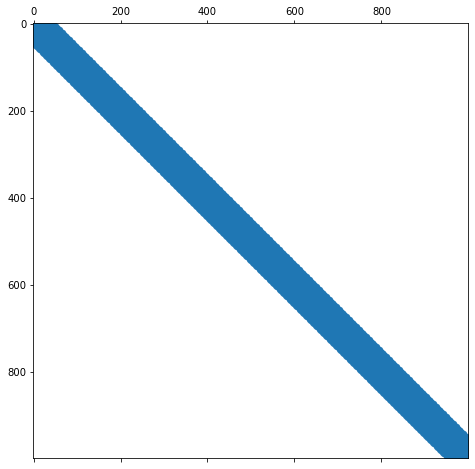

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8 ,8))
ax = fig.add_subplot(111)
ax.spy(M, markersize=1)

Let us check the condition number of the right-preconditioned system.

In [14]:
np.linalg.cond(A.todense() @ M.todense())

40.18659718436073

It has been reduced by a factor 100. This is a good sign. We are now running CG for the preconditioned and non-preconditioned system.

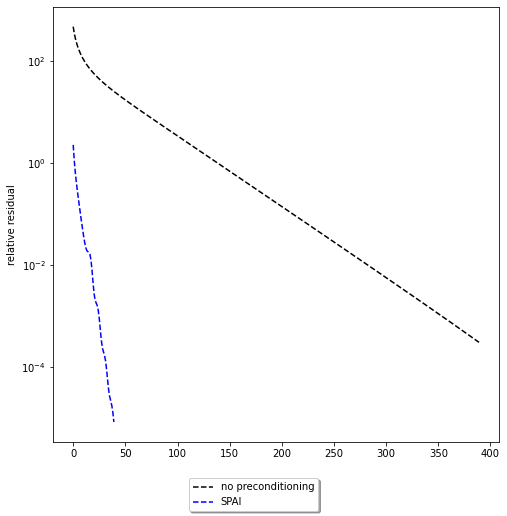

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.sparse.linalg import cg

n = A.shape[0]
b = np.ones(n)

residuals = []
callback = lambda x: residuals.append(np.linalg.norm(A @ x - b))
x, _ = cg(A, b, callback=callback)

residuals_preconditioned = []
callback = lambda x: residuals_preconditioned.append(np.linalg.norm(A @ x - b) / np.linalg.norm(b))
x, _ = cg(A, b, M=M, callback=callback)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.semilogy(residuals, 'k--')
ax.semilogy(residuals_preconditioned, 'b--')
ax.set_ylabel('relative residual')
fig.legend(['no preconditioning', 'SPAI'], loc='lower center', fancybox=True, shadow=True)

We can see a significant improvement in the number of iterations. However, the comparison is not quite fair. Setting up the preconditioner took time, which should be taken into account. Just considering number of iterations is not sufficient. In practice, the overall computation time is the much more important measure. We have implemented here a very primitive variant of SPAI that should not be used in practice. For practical alternatives see the cited literature. For the type of matrix that $A$ is there are also much better precondtioners available, some of which we will encounter later.

## A note on preconditioned Conjugate Gradient

We have passed here the preconditioner as a matrix into the CG algorithm. This is possible if the preconditioner is also symmetric, positive definite. This is the case in our example. We are not going to discuss the details of preconditioned conjugate gradients in more details here and refer to the book by Saad.